In [1]:
#from https://www.datacamp.com/community/tutorials/autoencoder-classifier-python#import keras
import os
import time
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Input,Dense,Flatten,Dropout,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adadelta, RMSprop,SGD,Adam
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from keras.utils import to_categorical
import cv2

Using TensorFlow backend.


In [2]:
image_size = 128

In [3]:
train_dir = "data/chest_xray/train/"
test_dir =  "data/chest_xray/test/"
def get_data(folder):
    X = []
    y = []
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ['NORMAL']:
                label = 0
            elif folderName in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
            for image_filename in tqdm(os.listdir(folder + folderName)):
                img_file = cv2.imread(folder + folderName + '/' + image_filename, cv2.IMREAD_GRAYSCALE)
                if img_file is not None:
                    img_file = cv2.resize(img_file, (image_size, image_size) , interpolation=cv2.INTER_CUBIC) 
                    # resize(img_file, (1024, 1024))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

if os.path.isfile("X_train-pneunonia-grayscale-"+str(image_size)+".npz") and \
    os.access("X_train-pneunonia-grayscale-"+str(image_size)+".npz", os.R_OK) and \
    os.path.isfile("y_train-pneunonia-grayscale-"+str(image_size)+".npz") and \
    os.access("y_train-pneunonia-grayscale-"+str(image_size)+".npz", os.R_OK) and  \
    os.path.isfile("X_test-pneunonia-grayscale-"+str(image_size)+".npz") and \
    os.access("X_test-pneunonia-grayscale-"+str(image_size)+".npz", os.R_OK) and \
    os.path.isfile("y_test-pneunonia-grayscale-"+str(image_size)+".npz") and \
    os.access("y_test-pneunonia-grayscale-"+str(image_size)+".npz", os.R_OK):
    print("Files exist and are readable")
    ## load data of converted images from NPZ
    X_train = np.load("X_train-pneunonia-grayscale-"+str(image_size)+".npz")['arr_0']
    y_train = np.load("y_train-pneunonia-grayscale-"+str(image_size)+".npz")['arr_0']
    X_test = np.load("X_test-pneunonia-grayscale-"+str(image_size)+".npz")['arr_0']
    y_test = np.load("y_test-pneunonia-grayscale-"+str(image_size)+".npz")['arr_0']
else:
    X_train, y_train = get_data(train_dir)
    X_test, y_test= get_data(test_dir)
    ## save to npy file
    from numpy import savez_compressed
    savez_compressed("X_train-pneunonia-grayscale-"+str(image_size)+".npz", X_train)
    savez_compressed("y_train-pneunonia-grayscale-"+str(image_size)+".npz", y_train)
    savez_compressed("X_test-pneunonia-grayscale-"+str(image_size)+".npz", X_test)
    savez_compressed("y_test-pneunonia-grayscale-"+str(image_size)+".npz", y_test)
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
from keras.utils.np_utils import to_categorical
y_trainHot = to_categorical(y_train, num_classes = 2)
y_testHot = to_categorical(y_test, num_classes = 2)

Files exist and are readable


In [4]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5216, 128, 128)
(5216,)
(624, 128, 128)
(624,)


In [5]:
#train_data = extract_data('train-images-idx3-ubyte.gz', 60000)
#test_data = extract_data('t10k-images-idx3-ubyte.gz', 10000)
train_data = X_train
test_data = X_test
print(train_data.shape)
print(test_data.shape)


(5216, 128, 128)
(624, 128, 128)


In [6]:
#train_labels = extract_labels('train-labels-idx1-ubyte.gz',60000)
#test_labels = extract_labels('t10k-labels-idx1-ubyte.gz',10000)
train_labels = y_train
test_labels = y_test
print(train_labels.shape)
print(test_labels.shape)

(5216,)
(624,)


In [7]:
# Shapes of training set
print("Training set (images) shape: {shape}".format(shape=train_data.shape))

# Shapes of test set
print("Test set (images) shape: {shape}".format(shape=test_data.shape))


Training set (images) shape: (5216, 128, 128)
Test set (images) shape: (624, 128, 128)


Text(0.5, 1.0, '(Label: Yes)')

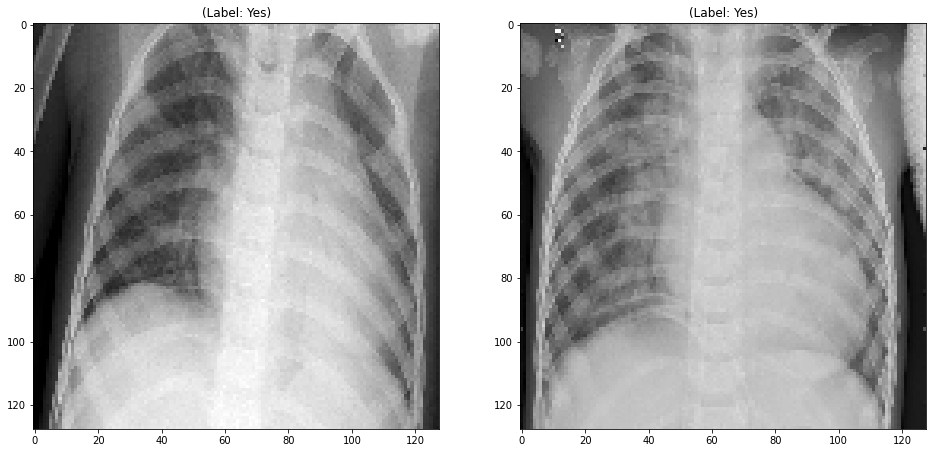

In [8]:
# Create dictionary of target classes
label_dict = {
 0: 'No',
 1: 'Yes'
}
plt.figure(figsize=[16,16])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(train_data[10], (image_size,image_size))
curr_lbl = train_labels[10]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(test_data[10], (image_size,image_size))
curr_lbl = test_labels[10]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

In [9]:
train_data = train_data.reshape(-1, image_size,image_size, 1)
test_data = test_data.reshape(-1, image_size,image_size, 1)
train_data.shape, test_data.shape

((5216, 128, 128, 1), (624, 128, 128, 1))

In [10]:
train_data.dtype, test_data.dtype

(dtype('uint8'), dtype('uint8'))

In [11]:
np.max(train_data), np.max(test_data)

(255, 255)

In [12]:
train_data = train_data / np.max(train_data)
test_data = test_data / np.max(test_data)

In [13]:
np.max(train_data), np.max(test_data)

(1.0, 1.0)

In [14]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(train_data,
                                                             train_data,
                                                             test_size=0.2,
                                                             random_state=13)

In [16]:

batch_size = 16
epochs = 64
inChannel = 1
x, y = image_size, image_size
input_img = Input(shape = (x, y, inChannel))
def encoder(input_img):
    #encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

def decoder(conv4):    
    #decoder
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) #7 x 7 x 128
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5) #7 x 7 x 64
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D((2,2))(conv6) #14 x 14 x 64
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 32
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((2,2))(conv7) # 28 x 28 x 32
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [17]:
autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop(lr=0.0005))

In [42]:
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 128, 128, 32)      320       
_________________________________________________________________
batch_normalization_28 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_29 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 64, 64, 64)        1849

In [44]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=2,validation_data=(valid_X, valid_ground))

Epoch 1/64
261/261 - 54s - loss: 8.6945e-04 - val_loss: 0.0013
Epoch 2/64
261/261 - 55s - loss: 8.7255e-04 - val_loss: 6.7405e-04
Epoch 3/64
261/261 - 55s - loss: 8.5197e-04 - val_loss: 7.5779e-04
Epoch 4/64
261/261 - 55s - loss: 8.4955e-04 - val_loss: 0.0036
Epoch 5/64
261/261 - 55s - loss: 8.2965e-04 - val_loss: 0.0022
Epoch 6/64
261/261 - 55s - loss: 8.2935e-04 - val_loss: 8.6199e-04
Epoch 7/64
261/261 - 55s - loss: 8.4259e-04 - val_loss: 6.3126e-04
Epoch 8/64
261/261 - 55s - loss: 8.2527e-04 - val_loss: 7.4928e-04
Epoch 9/64
261/261 - 55s - loss: 7.9868e-04 - val_loss: 7.5065e-04
Epoch 10/64
261/261 - 55s - loss: 8.1414e-04 - val_loss: 5.8573e-04
Epoch 11/64
261/261 - 55s - loss: 8.0931e-04 - val_loss: 7.8137e-04
Epoch 12/64
261/261 - 55s - loss: 7.8123e-04 - val_loss: 6.5949e-04
Epoch 13/64
261/261 - 55s - loss: 7.9320e-04 - val_loss: 6.8333e-04
Epoch 14/64
261/261 - 55s - loss: 7.7016e-04 - val_loss: 6.7152e-04
Epoch 15/64
261/261 - 55s - loss: 7.7984e-04 - val_loss: 0.0028
Epoch

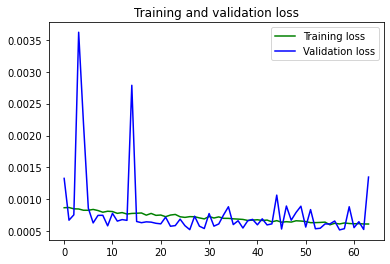

In [47]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs_R = range(epochs)
plt.figure()
plt.plot(epochs_R, loss, 'g', label='Training loss')
plt.plot(epochs_R, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()
autoencoder.save_weights('autoencoder.h5')

In [19]:
# Display the change for category label using one-hot encoding
print('Original label:', y_train[0])
print('After conversion to one-hot:', y_trainHot[0])

Original label: 1
After conversion to one-hot: [0. 1.]


In [26]:
train_X,valid_X,train_label,valid_label = train_test_split(train_data,y_trainHot,test_size=0.2,random_state=13)

In [27]:
train_X.shape,valid_X.shape,train_label.shape,valid_label.shape

((4172, 128, 128, 1), (1044, 128, 128, 1), (4172, 2), (1044, 2))

In [29]:
def fc(enco):
    flat = Flatten()(enco)
    den = Dense(128, activation='relu')(flat)
    out = Dense(num_classes, activation='tanh')(den)
    return out
encode = encoder(input_img)
full_model = Model(input_img,fc(encode))

ResourceExhaustedError: OOM when allocating tensor with shape[262144,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]